In [1]:
%matplotlib inline
import scipy.io as sio
import random
import numpy as np
import scipy.misc as smp
import matplotlib.pyplot as plt
import cv2
from scipy.special import expit

In [2]:
a = sio.loadmat('ex3data1.mat')
x_data = np.array(a['X']) 
y_data = np.array(a['y'])

print "Shapes ", x_data.shape, y_data.shape

Shapes  (5000, 400) (5000, 1)


In [3]:
#Display 100 random numbers. First grab images + reshape
hund = random.sample(range(0,5000), 100)
data_20x20 = [ np.reshape(x_data[im],(20,20)) for im in hund ]

images = [ smp.toimage( data_20x20[i]) for i in xrange(len(data_20x20)) ]             

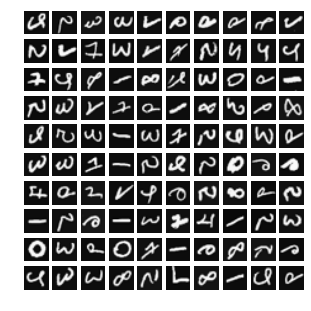

In [4]:
# Images are rotated for now. Will fix this in the future
plt.figure(figsize=(5,5))

for i in xrange(len(images)):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i],cmap='Greys_r')
    plt.axis('off')

plt.show()

x_data = np.insert(x_data,0,1,axis=1)

In [5]:
def h(x,theta):
    z = -1 * np.dot(x,theta) 
    return 1./(1 + np.exp(z)) 

def computeCost(theta,x,y,lam=0.):

    logs = np.dot(-1*y,np.log(h(x,theta)).T) - \
           np.dot(1-y, np.log(1-h(x,theta)).T) #(5000,5000)
    
    reg = np.dot(theta.T,theta) * lam/(2*len(y)) #shape: (1,1)
    
    #\print "LOGS" ,logs.shape
    return 1./len(y) * logs + reg


def getPartials(theta,x,y,lam=0.):

    part = 1./len(y) * np.dot(x.T,h(x,theta) - y.T)
    reg  = lam/len(y) * theta[1:]
    part[1:] += reg 
    
    return part

In [6]:
# suggested fmincg exists in python! word
from scipy.optimize import fmin_cg

def optimizeParams(theta,x,y,lam=0.):
    xopt = fmin_cg(computeCost, fprime=getPartials, x0=theta,args=(x,y,lam),maxiter=100,full_output=True)
    return xopt[0], xopt[1]

def getThetas(x,y,lam=0.):

    init_theta = np.zeros((x.shape[1],1)).reshape(-1)
    final_theta = np.zeros((10,x.shape[1]))
    for i in xrange(10):
        y_test = np.array(np.zeros(5000))
        y_test[i*500:(i+1)*500] = 1
        
        opt_theta, _ = optimizeParams(init_theta,x,y_test,lam)
        final_theta[i,:] = opt_theta  
    
    return final_theta

In [7]:
theta_params = getThetas(x_data,y_data,0)
#theta_params = buildTheta(x_data,y_data)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


         Current function value: nan
         Iterations: 100
         Function evaluations: 568
         Gradient evaluations: 568
         Current function value: 0.001840
         Iterations: 100
         Function evaluations: 409
         Gradient evaluations: 409
         Current function value: 0.045241
         Iterations: 100
         Function evaluations: 289
         Gradient evaluations: 289
         Current function value: 0.052888
         Iterations: 100
         Function evaluations: 293
         Gradient evaluations: 293
         Current function value: 0.021517
         Iterations: 100
         Function evaluations: 322
         Gradient evaluations: 322
         Current function value: 0.048155
         Iterations: 100
         Function evaluations: 288
         Gradient evaluations: 288
         Current function value: 0.002976
         Iterations: 100
         Function evaluations: 392
         Gradient evaluations: 392
         Current function value: 0.023165
    

In [8]:
# Loop over all 10 theta parameterizations.
# Which produces the best hypothesis? (ie class, 0, 1, 2...)
def predictOneVsAll(theta,xi):
    
    classes = range(0,10)
    classes[0] = 10
    hypoth  = [0] * len(classes)
    
    for i in xrange(len(classes)):
        hypoth[i] = h(theta[i],xi)
           
    max_it = hypoth.index(max(hypoth))
    
    return classes[max_it]        

In [9]:
correct = 0
for i in xrange(x_data.shape[0]):
    y_predict = predictOneVsAll(theta_params,x_data[i])
    
    if y_predict == y_data[i]:
        correct += 1.
        
print "How'd we do? ", correct / x_data.shape[0] * 100 ,"%"

How'd we do?  91.26 %


2 Neural Networks

In [10]:
b = sio.loadmat('ex3weights.mat')

#np.array(a['X'])
theta2 = b['Theta2'] 
theta1 = b['Theta1']

print "Shapes ", theta1.shape, theta2.shape, x_data.shape
#x_data = np.insert(x_data,0,1,axis=1)

Shapes  (25, 401) (10, 26) (5000, 401)


In [11]:
def predict(t1,t2,xi):
    
    # Perform feedforward
    z = h(xi,t1.T)
    z1 = np.insert(z,0,1,axis=0)
    hypoth = h(z1,t2.T)

    # Again, calculate the prediction
    classes = range(0,10)
    classes[0] = 10
    
    # This doesn't work for numpy array apparently
    #max_it = hypoth.index(max(hypoth))
    max_it = hypoth.argmax()
    
    return classes[max_it]

In [12]:
for i in xrange(len(x_data)):
    out = predict(theta1,theta2,x_data[i])
    
    if out == y_data[i]:
        correct += 1

print "Our success rate is: ", float(correct)/len(x_data) * 100, "%"

Our success rate is:  91.38 %


In [13]:
# Note to future self: Would be interesting to understand
# why the success rates are lower than expected.  Could this have
# anything to do with image's rotation? It shouldn't. But hm. 
# Increasing number of iterations in fmin_cg might affect the result, 
#but causes large slow down